# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add TSE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/TSE")

CPU times: user 210 µs, sys: 141 µs, total: 351 µs
Wall time: 252 µs


# Overview

In the following notebok we evaluate the Trajectory-Stretching-Exponents $ (\mathrm{TSE}, \mathrm{\overline{TSE}) $ on a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data
 <br />
5. Trajectory Stretching Exponent $ \mathrm{TSE} $ and averaged Trajectory Stretching Exponent $ \mathrm{\overline{TSE}} $ :
    
    * Compute velocity along trajectories $ \lbrace \mathbf{\dot{x}}(t_{i}) \rbrace_{i=0}^N $ over the time interval $ [t_0, t_N] $.
    
    * Compute $ \mathrm{TSE} $ from velocity along trajectories:
    
    \begin{equation}
        \mathrm{TSE}_{t_0}^{t_N} = \dfrac{1}{t_N-t_0} \log{\dfrac{\sqrt{|\mathbf{\dot{x}}(t_N)|^2 +\mathrm{v}_0^2}}{\sqrt{|\mathbf{\dot{x}}(t_0)|^2 +\mathrm{v}_0^2}}}
    \end{equation}
    
    * Compute $ \mathrm{\overline{TSE}} $ from velocity along trajectories:
    
    \begin{equation}
        \mathrm{\overline{TSE}}_{t_0}^{t_N} = \dfrac{1}{t_N-t_0} \sum_{i=0}^{N-1}|\log{\dfrac{\sqrt{|\mathbf{\dot{x}}(t_{i+1})|^2 +\mathrm{v}_0^2}}{\sqrt{|\mathbf{\dot{x}}(t_i)|^2 +\mathrm{v}_0^2}}}|
    \end{equation}
    
    $ \mathrm{v}_0 $ is a characteristic velocity, which can be be estimated by taking the spatio-temporal average of the velocity over the whole dataset.

# Import Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

CPU times: user 159 ms, sys: 42.1 ms, total: 201 ms
Wall time: 202 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 18

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

# set nan values

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# time step-size (in days)
dt = .1

time = np.arange(t0, tN+dt, dt)

# length of time interval (in days)
lenT = tN-t0

# longitudinal and latitudinal boundaries (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# make sure that domain is in the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"
    
# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# Size of arrays
Nx = X_domain.shape[1]
Ny = Y_domain.shape[0]

CPU times: user 1.2 ms, sys: 1.25 ms, total: 2.45 ms
Wall time: 1.36 ms


# Velocity interpolation

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant.

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time, method = "cubic")

CPU times: user 79.1 ms, sys: 22.4 ms, total: 101 ms
Wall time: 101 ms


# Trajectory Stretching Exponent

In [6]:
%%time
# Import package for computing trajectories/velocity
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import package which checks particle location
from ipynb.fs.defs.check_location import check_location

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package for TSE/TSE_bar
from ipynb.fs.defs.TSE import _TSE, _TSE_bar

# set v0 equal to the average velocity in the Agulhas region
v0 = 0.2 # This can be either calculated or estimated.

def parallel_TSE(i):
    
    TSE_parallel = X_domain[0,:].copy()*np.nan
    
    TSE_bar_parallel = X_domain[0,:].copy()*np.nan
    
    for j in range(X_domain.shape[1]):
        
        # set initial condition
        x = np.array([X_domain[i, j], Y_domain[i, j]])
        
        # only compute TSE for trajectories starting region where velocity field is defined
        if check_location(X, Y, defined_domain, x)[0] == "IN":
    
            # compute trajectory/velocity
            Fmap, dFdt = integration_dFdt(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta)
        
            TSE_parallel[j] = _TSE(lenT, dFdt, v0)
            TSE_bar_parallel[j] = _TSE_bar(lenT, dFdt, v0)
            
        else:
            
            TSE_parallel[j] = np.nan
            TSE_bar_parallel[j] = np.nan
        
    return TSE_parallel, TSE_bar_parallel

results_TSE = np.array(Parallel(n_jobs=Ncores)(delayed(parallel_TSE)(i) for i in tqdm(range(X_domain.shape[0]))))

# extract TSE/TSE_bar from results of parallel computation
TSE = results_TSE[:,0,:]
TSE_bar = results_TSE[:,1,:]

  0%|          | 0/401 [00:00<?, ?it/s]

CPU times: user 7.45 s, sys: 3.5 s, total: 11 s
Wall time: 1min 28s


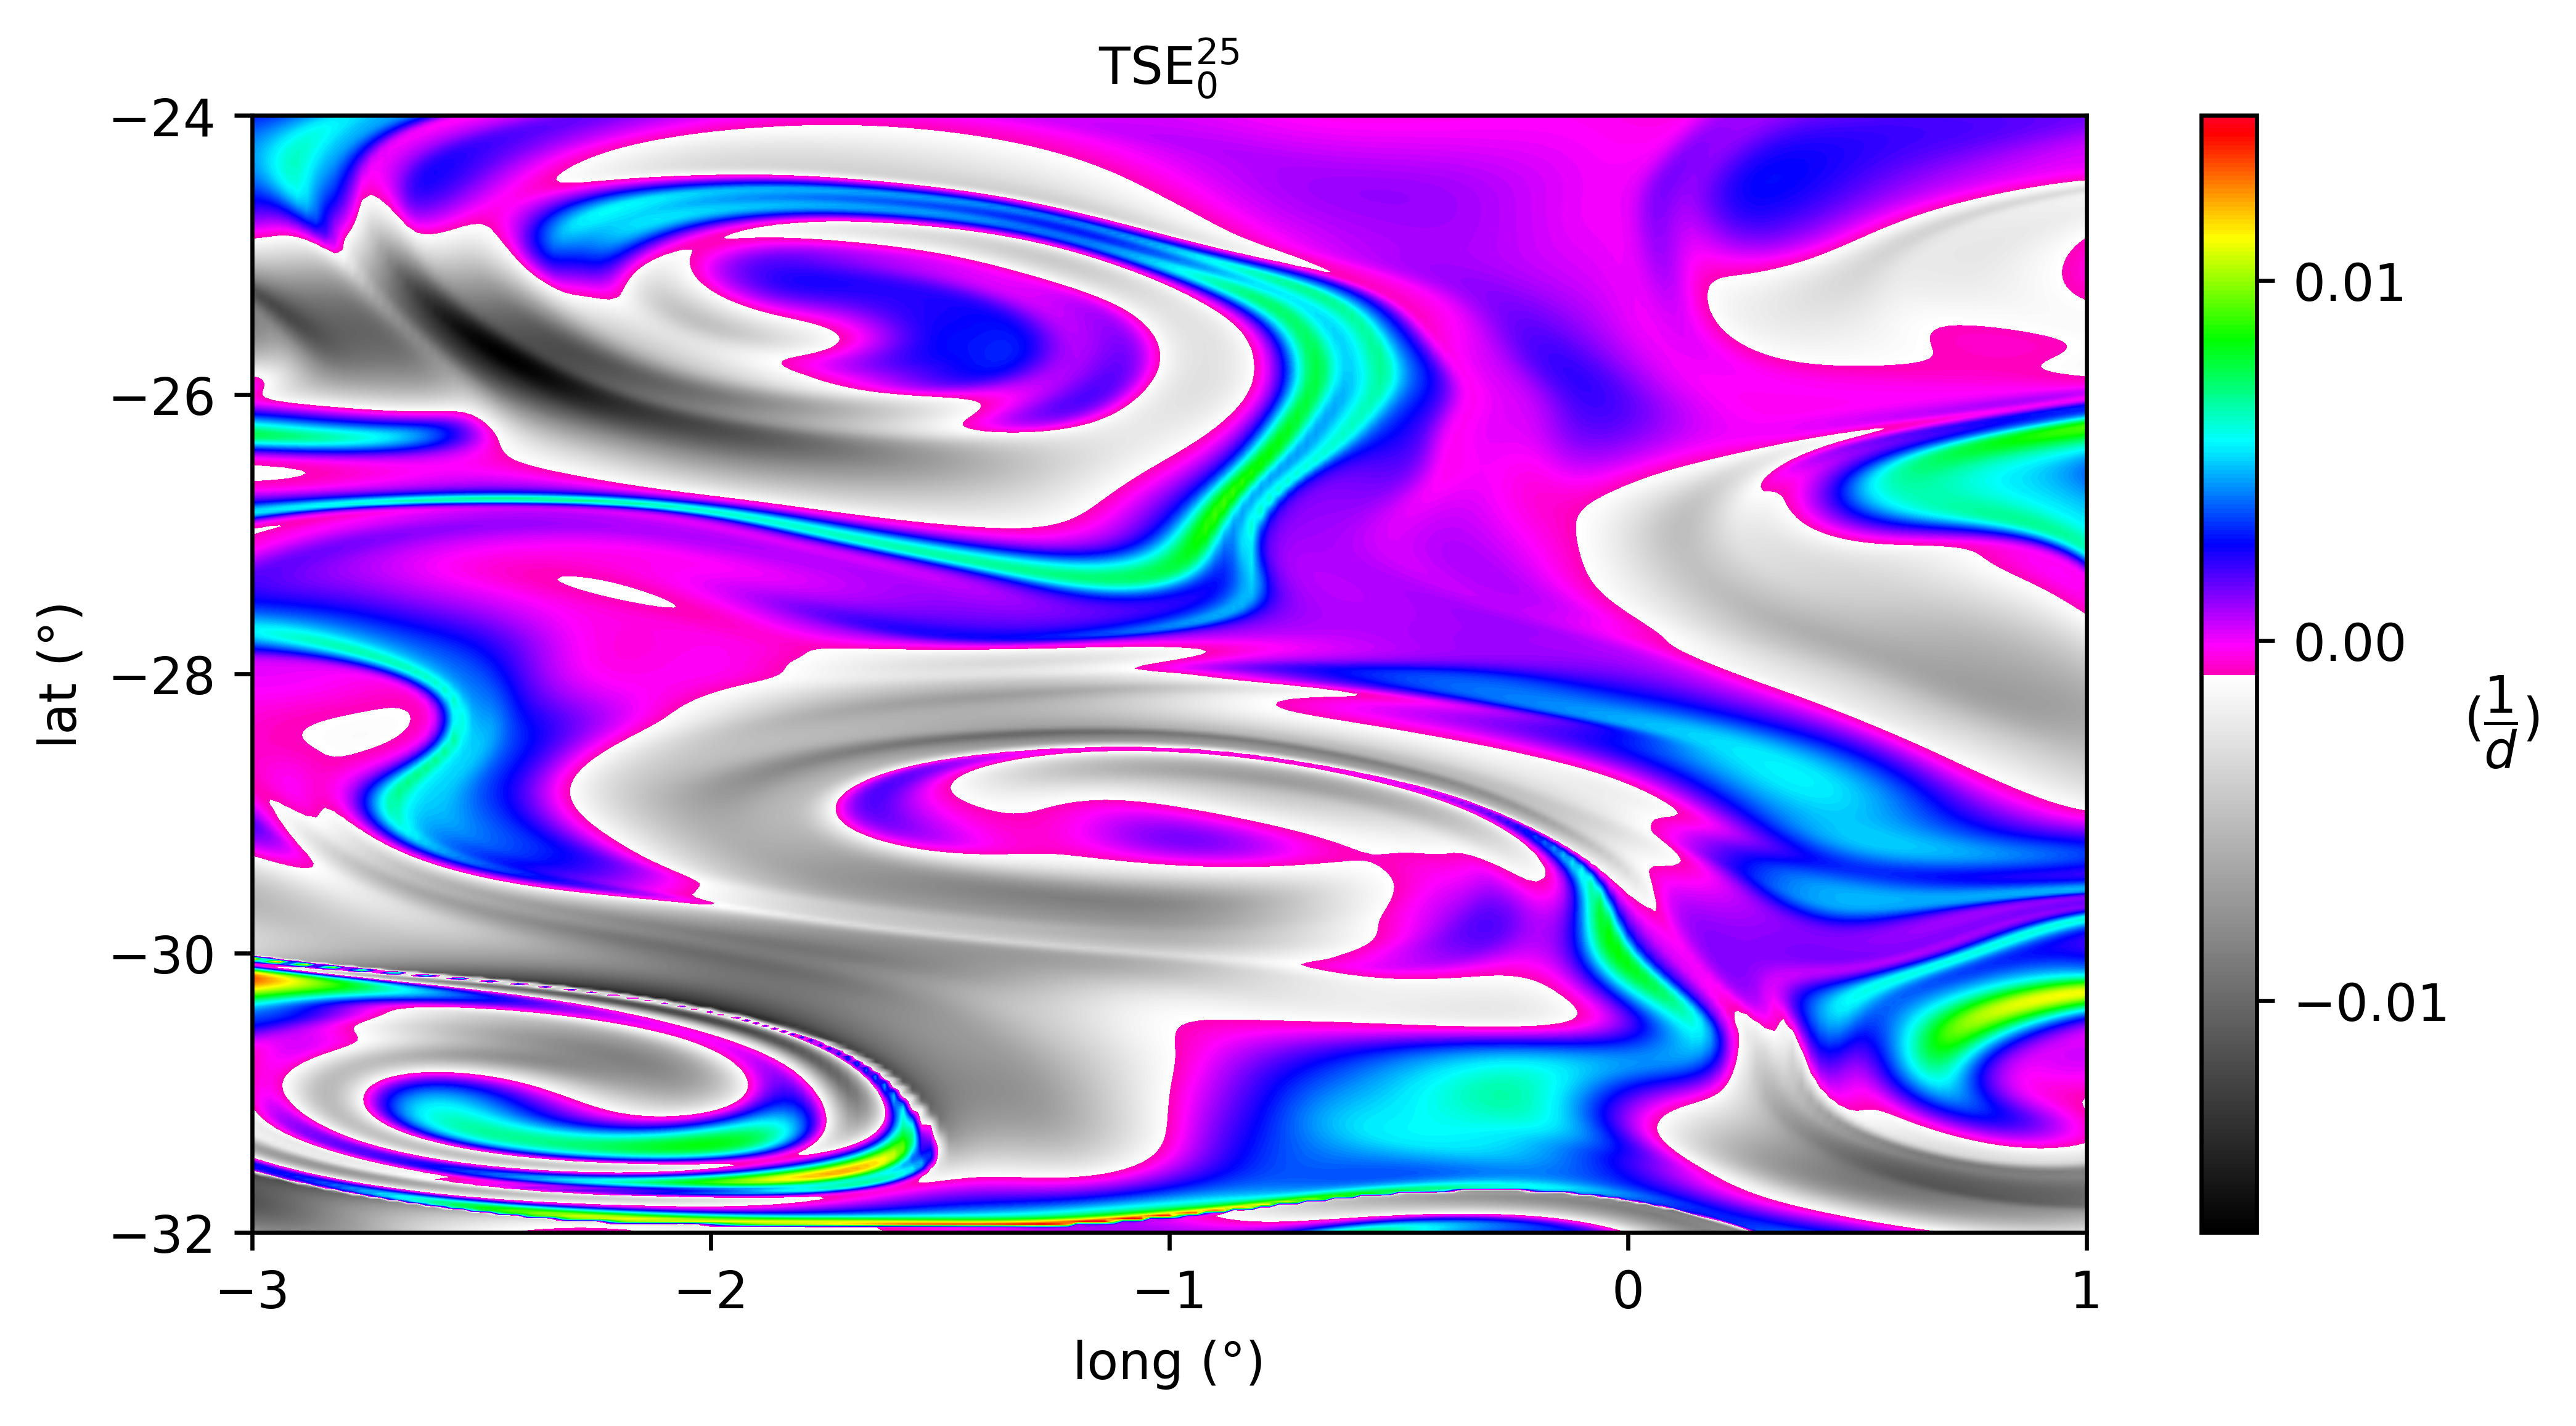

In [10]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.binary_r(np.linspace(0, 1, 128))
colors2 = plt.cm.gist_rainbow_r(np.linspace(0, 1, 128))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(TSE), cmap = mymap, levels = 600)

cax.cmap.set_under('w')

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+0.1, 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+0.1, 2))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(-0.04, 0.04, 9))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 10, fontsize = 10)

ax.set_title(r'$\mathrm{TSE}$' + f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$', fontsize = 10)

plt.show()

# averaged Trajectory Stretching Exponent ($ \mathrm{\overline{TSE}}$)

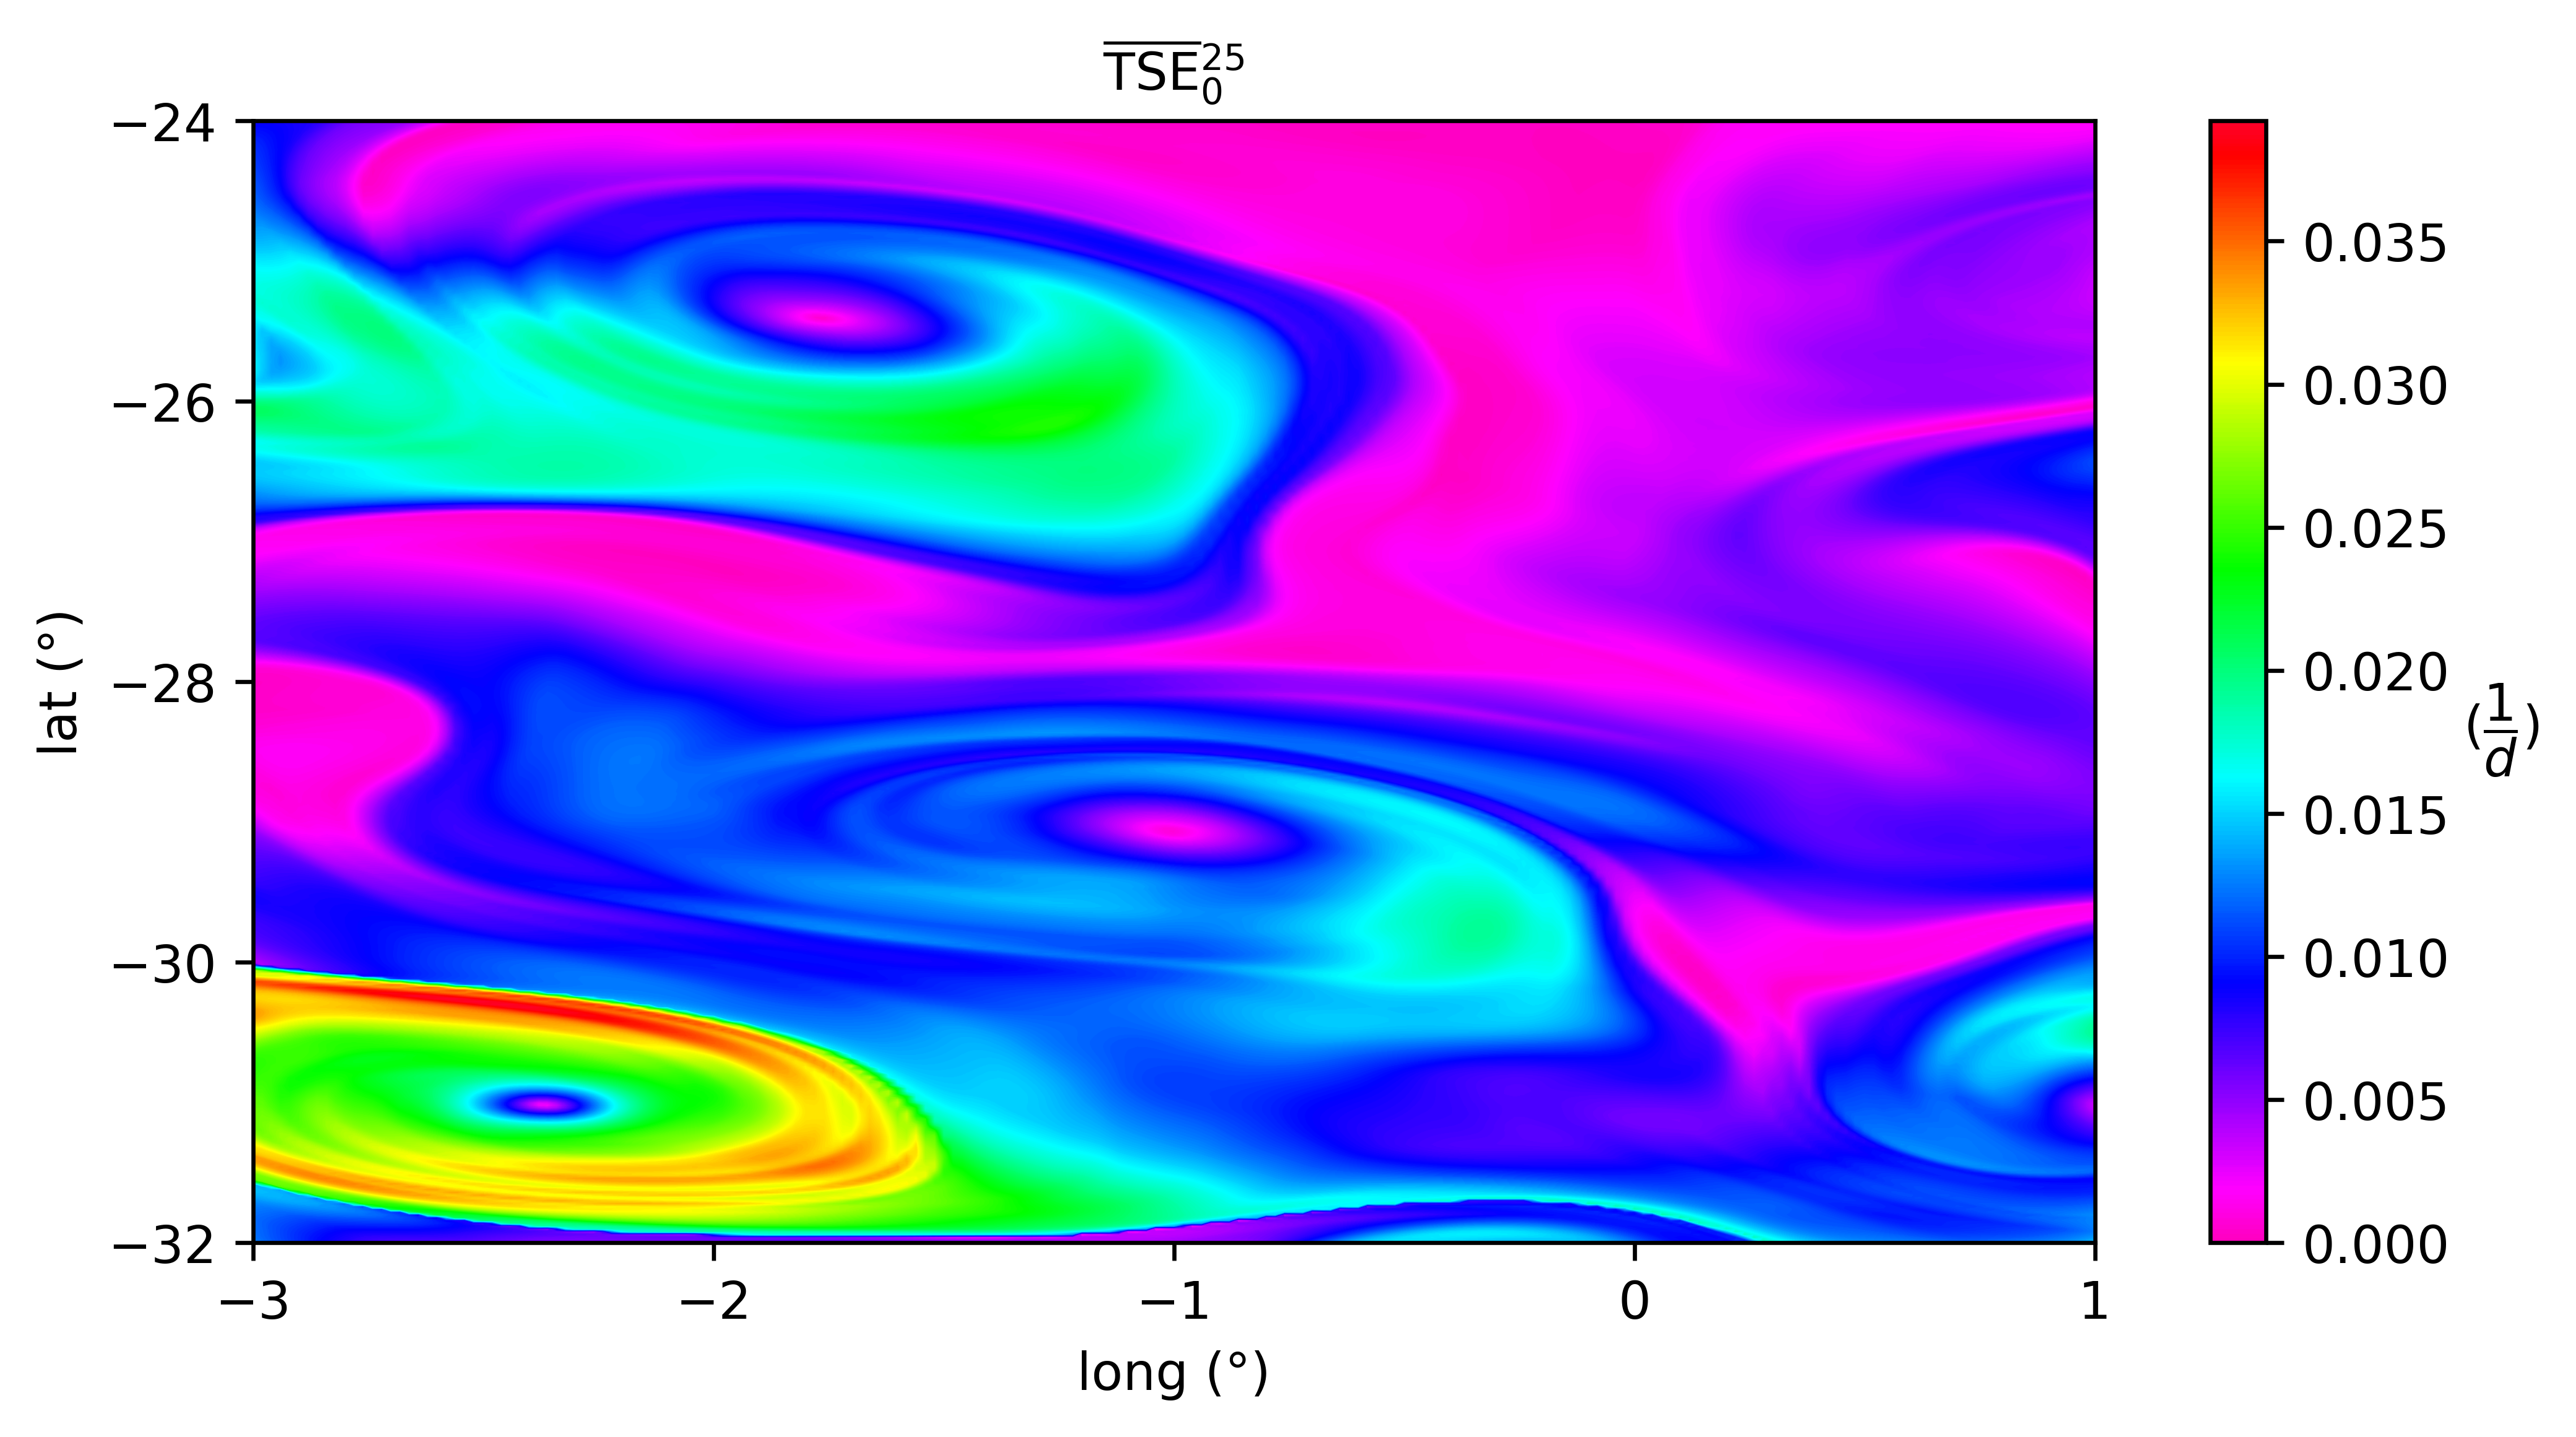

In [9]:
######################## PLOT RESULTS ########################
import matplotlib.colors as colors

# Figure/Axis
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(TSE_bar), levels = 600, cmap = "gist_rainbow_r")

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+0.1, 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+0.2, 2))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, 0.2, 41))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 10, fontsize = 10)

ax.set_title(r'$\mathrm{\overline{TSE}}$' + f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$', fontsize = 10)

plt.show()

The $ \mathrm{\overline{TSE}}_{t_0}^{t_N} $ and the $ \mathrm{TSE}_{t_0}^{t_N} $ are single trajectory indicators for hyperbolic LCS. The ridges of $ \mathrm{TSE}_{t_0}^{t_N} $ approximate the major ridges of the FTLE field (see [FTLE](../../FTLE/Main/FTLEAgulhas.ipynb)) at a much lower computational cost as there is no need to compute the spatial derivatives involved when evaluating the FTLE-field.

# References

[1] Haller, G., Aksamit, N., & Encinas-Bartos, A. P. (2021). Quasi-objective coherent structure diagnostics from single trajectories. Chaos: An Interdisciplinary Journal of Nonlinear Science, 31(4), 043131.